In [39]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/temperature-readings-iot-devices/IOT-temp.csv


In [3]:
data = pd.read_csv('/kaggle/input/temperature-readings-iot-devices/IOT-temp.csv')

In [4]:
data.groupby('out/in').describe()

temp                                                   
          count       mean       std   min   25%   50%   75%   max
out/in                                                            
In      20345.0  30.453920  2.238101  21.0  29.0  31.0  32.0  41.0
Out     77261.0  36.265244  5.717055  24.0  31.0  37.0  40.0  51.0

<AxesSubplot:xlabel='noted_date'>

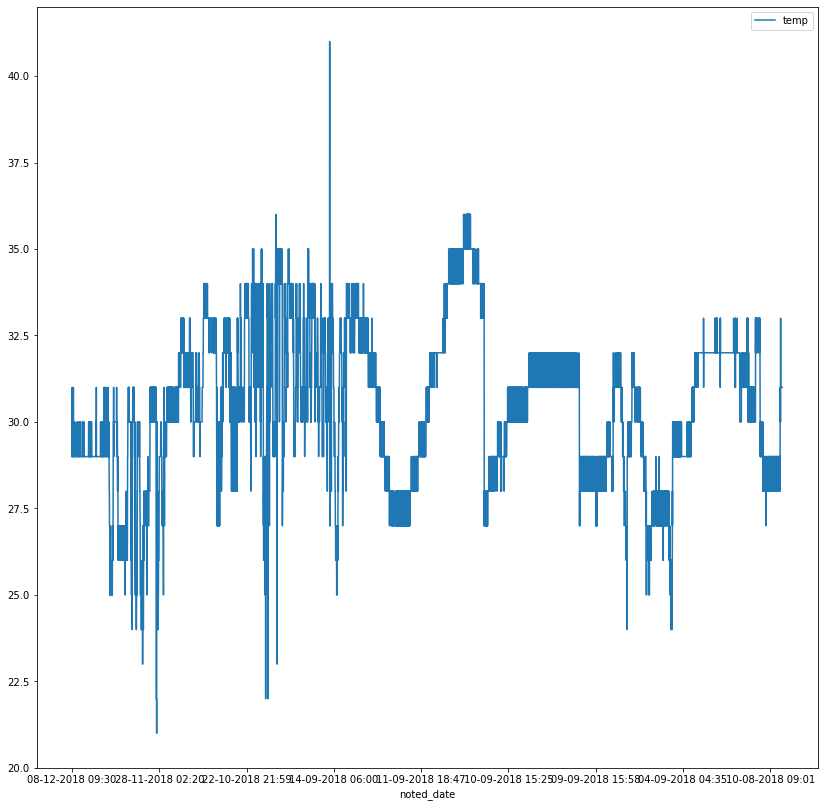

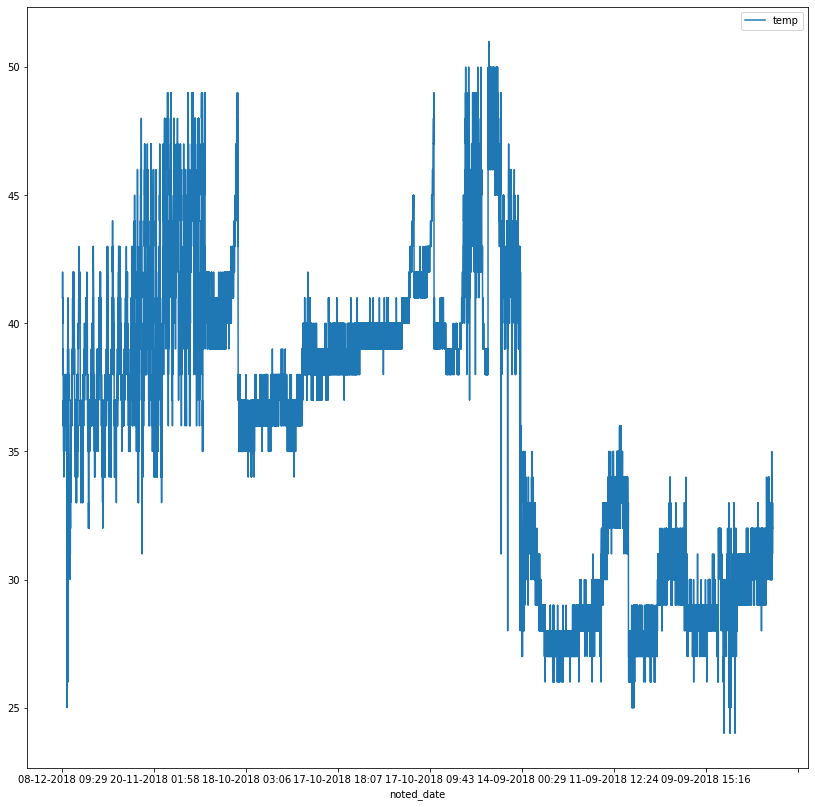

In [5]:
# separate between in ds and out ds

ds = data[['noted_date', 'temp', 'out/in']]
in_ds = ds[ds['out/in'] == 'In']

in_ds.plot(
    x='noted_date',
    y='temp',
    figsize=(14, 14)
)

out_ds = ds[ds['out/in'] == 'Out']

out_ds.plot(
    x='noted_date',
    y='temp',
    figsize=(14, 14)
)

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
dataset = out_ds['temp'].astype(float).values

data_shape = dataset.shape[0]
val_split = 0.2
test_split = 0.1

# training split will have 70% of data, validation 20%, test 10%
train_ds = dataset[:int(data_shape*(1-val_split-test_split))]
val_ds = dataset[int(data_shape*(1-val_split-test_split)):int(data_shape*(1-test_split))]
test_ds = dataset[int(data_shape*(1-test_split)):]

In [8]:
# using LSTM to predict for the next 60 data points

train_set = windowed_dataset(train_ds, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(train_ds, window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [9]:
## early stopping to keep model simple
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      min_delta=0.0001, 
                                      patience=5, 
                                      verbose=0, 
                                      mode='auto')

Learning rate schedule: 1e-05 to 0.0005 to 0.0001


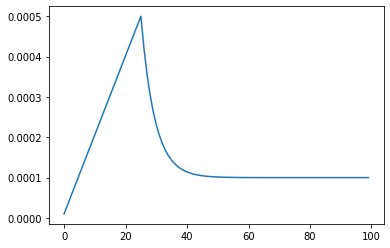

In [10]:
LR_START = 0.00001
LR_MAX = 0.0005
LR_MIN = 0.0001
LR_RAMPUP_EPOCHS = 25
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8
EPOCHS = 100

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [11]:
optimizer = tf.keras.optimizers.SGD(momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,
                    validation_data=val_set,
                    callbacks = [es_callback, lr_callback],
                    epochs=EPOCHS)

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 1e-05.
541/541 [==============================] - 27s 37ms/step - loss: 38.1912 - mae: 38.6912 - val_loss: 37.7486 - val_mae: 38.2486
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 2.96e-05.
541/541 [==============================] - 19s 34ms/step - loss: 35.4832 - mae: 35.9832 - val_loss: 30.4525 - val_mae: 30.9525
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 4.9199999999999997e-05.
541/541 [==============================] - 20s 37ms/step - loss: 6.7437 - mae: 7.1581 - val_loss: 11.7242 - val_mae: 12.2220
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 6.879999999999999e-05.
541/541 [==============================] - 19s 34ms/step - loss: 1.6034 - mae: 1.9990 - val_loss: 10.2950 - val_mae: 10.7888
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 8.84e-05.
541/541 [==============================] - 18s 34ms/step 

(0.0, 40.09042241349816)

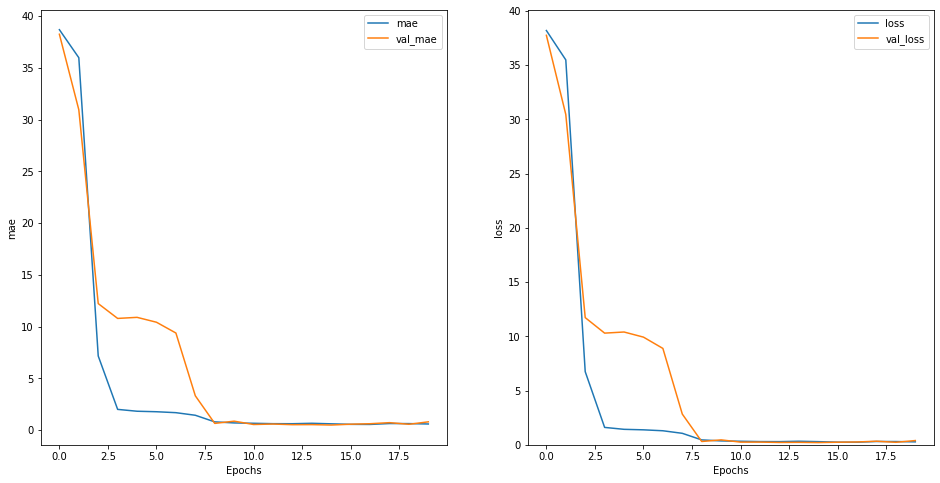

In [12]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'mae')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [13]:
test_set = windowed_dataset(test_ds, window_size=60, batch_size=100, shuffle_buffer=1000)
prediction = model.predict(test_set)

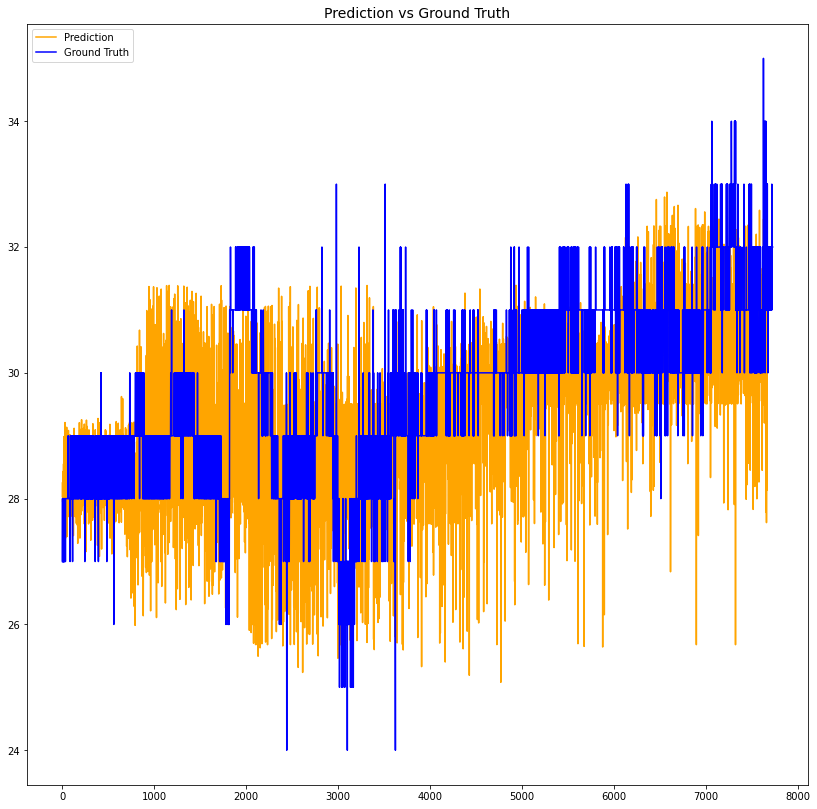

In [14]:
fig, ax = plt.subplots(figsize=(14,14))
ax.plot(
    prediction,
    color='orange',
    label='Prediction'
)
ax.plot(
    test_ds,
    color='blue',
    label='Ground Truth'
)
plt.title('Prediction vs Ground Truth', size=14)
plt.legend()
plt.show()

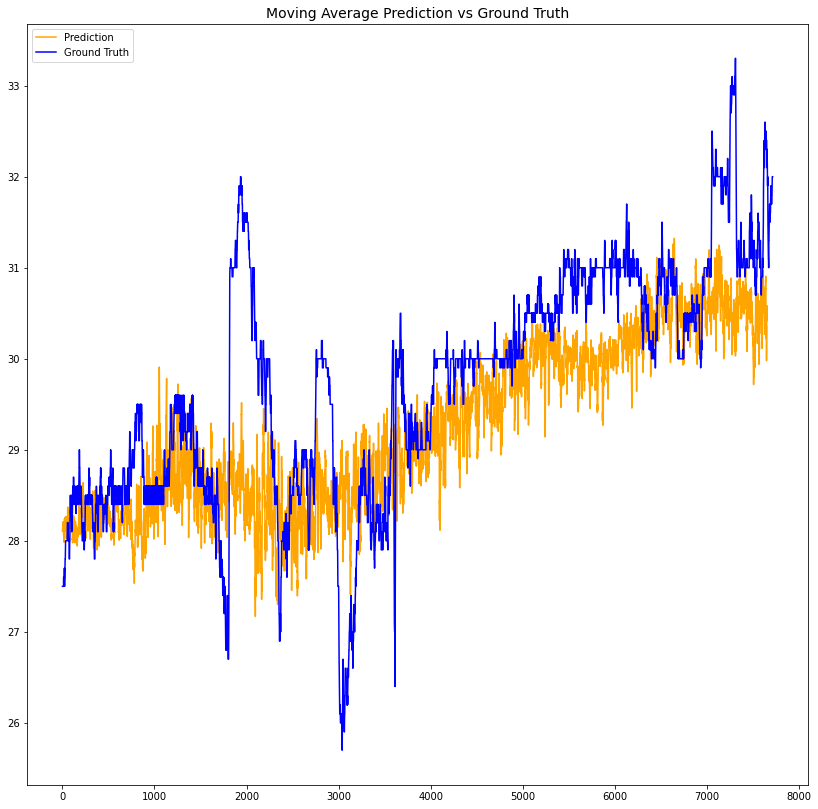

In [15]:
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


fig, ax = plt.subplots(figsize=(14,14))
ax.plot(
    moving_average(prediction),
    color='orange',
    label='Prediction'
)
ax.plot(
    moving_average(test_ds),
    color='blue',
    label='Ground Truth'
)
plt.title('Moving Average Prediction vs Ground Truth', size=14)
plt.legend()
plt.show()

In [32]:
# Calculate Mean Absolute Error (MAE)
mae = tf.keras.metrics.mean_absolute_error(actual_values, predictions).numpy().mean()
print(f'Mean Absolute Error on test set: {mae:.2f}')

# Calculate Mean Squared Error (MSE)
mse = tf.keras.metrics.mean_squared_error(actual_values, predictions).numpy().mean()
print(f'Mean Squared Error on test set: {mse:.2f}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error on test set: {rmse:.2f}')


Mean Absolute Error on test set: 1.11
Mean Squared Error on test set: 2.10
Root Mean Squared Error on test set: 1.45


In [38]:
import numpy as np

# Assuming predictions and actual_values are defined as before
threshold = 1.0  # Define a threshold 
# Calculate the number of accurate predictions
accurate_predictions = np.sum(np.abs(predictions - actual_values) <= threshold)

# Calculate total number of predictions
total_predictions = len(actual_values)

# Calculate accuracy percentage
accuracy_percentage = (accurate_predictions / total_predictions) * 100

print(f'Accuracy on test set: {accuracy_percentage:.2f}%')


Accuracy on test set: 56.97%
